# Character Based Named Entity Recognition Models

Done by Karthik Hegde (IMT2018509)

## BIO based character RNN model

In [107]:
import tensorflow as tf
from tensorflow import keras
import numpy as np
import pandas as pd
import re

In [108]:
!wget --no-check-certificate --content-disposition https://raw.githubusercontent.com/SilentFlame/Named-Entity-Recognition/master/Twitterdata/annotatedData.csv

--2021-02-08 15:02:38--  https://raw.githubusercontent.com/SilentFlame/Named-Entity-Recognition/master/Twitterdata/annotatedData.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 151.101.0.133, 151.101.64.133, 151.101.128.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|151.101.0.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1591322 (1.5M) [text/plain]
Saving to: ‘annotatedData.csv.1’

annotatedData.csv.1 100%[===================>]   1.52M  --.-KB/s    in 0.07s   

2021-02-08 15:02:39 (21.0 MB/s) - ‘annotatedData.csv.1’ saved [1591322/1591322]



In [109]:
annotatedData = pd.read_csv('/content/annotatedData.csv')

In [110]:
annotatedData

,Sent,Word,Tag
0,sent: 0,Bahubali,B-Per
1,sent: 0,2,Other
2,sent: 0,ke,Other
3,sent: 0,liye,Other
4,sent: 0,line,Other
...,...,...,...
72138,sent: 3637,udhr,Other
72139,sent: 3637,kar,Other
72140,sent: 3637,gya,Other
72141,sent: 3637,#pnb,B-Org


Dropping the rows containing missing values

In [111]:
annotatedData = annotatedData.dropna(axis=0)

In [112]:
annotatedData.shape

(68504, 3)

Splitting the words into characters and tagging them into 'B' (border), 'I' (Inside), 'O' (outside)

In [113]:
lst_ne = ['B-Per', 'B-Org', 'I-Org', 'B-Loc', 'I-Per', 'I-Loc']

sent_idx = []
word_idx = []
character = []
tag = []

idx = 0

# Tagging each character of the word as 'B', 'I', or 'O'
def Tag_char(row):
  global idx
  idx += 1

  sentence = str(row['Sent'])
  sentence_num = sentence[6:]
  word_string = str(row['Word'])

  if row['Tag'] in lst_ne:
    for ind, char in enumerate(word_string):
      sent_idx.append(sentence_num)
      word_idx.append(idx)
      if (ind==0 or ind==len(word_string)-1):
        character.append(char)
        tag.append('B')
      else:
        character.append(char)
        tag.append('I')
  else:
    for ind, char in enumerate(word_string):
      sent_idx.append(sentence_num)
      word_idx.append(idx)
      character.append(char)
      tag.append('O')

annotatedData.apply(Tag_char, axis=1)

Data = pd.DataFrame({'Sentence_index':sent_idx, 'Word_index': word_idx, 'Character': character, 'Tag': tag})

In [114]:
Data

,Sentence_index,Word_index,Character,Tag
0,0,1,B,B
1,0,1,a,I
2,0,1,h,I
3,0,1,u,I
4,0,1,b,I
...,...,...,...,...
294588,3637,68504,f,O
294589,3637,68504,r,O
294590,3637,68504,a,O
294591,3637,68504,u,O


Tokenizing the characters and tags

Each unique character and unique tag in the data is given an index number. There are only 3 tags ('B', 'I', 'O')

In [115]:
# Tokenizing the characters and Tags

def get_dict_map(data, char_or_tag):
  vocab = list(set(data[char_or_tag].to_list())) # converting to set to avoid duplicates
  token_to_index = {token:index for index, token in enumerate(vocab)} 
  index_to_token = {index:token for index, token in enumerate(vocab)} 
  return token_to_index, index_to_token

char_to_index, index_to_char = get_dict_map(Data, 'Character')
tag_to_index, index_to_tag = get_dict_map(Data, 'Tag')

# adding character_index, and tag_index to the Data
Data['Character_index'] = Data['Character'].map(char_to_index)
Data['Tag_index'] = Data['Tag'].map(tag_to_index)

In [116]:
# unique number of charaters
Data['Character_index'].nunique()

108

In [117]:
Data

,Sentence_index,Word_index,Character,Tag,Character_index,Tag_index
0,0,1,B,B,58,2
1,0,1,a,I,79,1
2,0,1,h,I,47,1
3,0,1,u,I,65,1
4,0,1,b,I,2,1
...,...,...,...,...,...,...
294588,3637,68504,f,O,83,0
294589,3637,68504,r,O,67,0
294590,3637,68504,a,O,79,0
294591,3637,68504,u,O,65,0


Grouping by the sentences.

In this case, the model is trained over sentences with each character of the sentence as the input unit. The model predicts tags for each character in the sentence. Finally the words of the sentence with BI...IB as the label are classified as Named Entities. 




In [118]:
# Group by the sentences
Data_group = Data.groupby('Sentence_index')[['Character', 'Tag', 'Character_index', 'Tag_index']].agg(list)

In [119]:
Data_group # there are 3085 unique sentences in the dataset

,Character,Tag,Character_index,Tag_index
Sentence_index,,,,
0,"[B, a, h, u, b, a, l, i, 2, k, e, l, i, y, e, ...","[B, I, I, I, I, I, I, B, O, O, O, O, O, O, O, ...","[58, 79, 47, 65, 2, 79, 4, 88, 28, 20, 59, 4, ...","[2, 1, 1, 1, 1, 1, 1, 2, 0, 0, 0, 0, 0, 0, 0, ..."
1,"[a, g, a, r, #, n, o, t, e, b, a, n, d, i, k, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[79, 51, 79, 67, 32, 76, 44, 6, 59, 2, 79, 76,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
10,"[#, n, o, t, e, b, a, n, d, i, k, e, b, a, a, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[32, 76, 44, 6, 59, 2, 79, 76, 66, 88, 20, 59,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
100,"[M, a, s, t, e, r, s, t, r, o, k, e, t, o, M, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, B, ...","[29, 79, 50, 6, 59, 67, 50, 6, 67, 44, 20, 59,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, ..."
1000,"[J, i, n, l, o, g, o, n, k, o, d, e, s, h, k, ...","[O, O, O, O, O, O, O, O, O, O, B, I, I, B, O, ...","[53, 88, 76, 4, 44, 51, 44, 76, 20, 44, 66, 59...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 2, 0, ..."
...,...,...,...,...
995,"[#, G, S, T, m, e, s, u, d, h, a, a, r, h, a, ...","[O, O, O, O, O, O, O, O, O, O, O, O, O, O, O, ...","[32, 105, 73, 94, 106, 59, 50, 65, 66, 47, 79,...","[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
996,"[M, o, d, i, j, i, i, s, l, i, k, e, P, e, h, ...","[B, I, I, B, B, B, O, O, O, O, O, O, O, O, O, ...","[29, 44, 66, 88, 56, 88, 88, 50, 4, 88, 20, 59...","[2, 1, 1, 2, 2, 2, 0, 0, 0, 0, 0, 0, 0, 0, 0, ..."
997,"[H, e, m, a, M, a, l, i, n, i, i, s, l, i, k, ...","[B, I, I, B, B, I, I, I, I, B, O, O, O, O, O, ...","[102, 59, 106, 79, 29, 79, 4, 88, 76, 88, 88, ...","[2, 1, 1, 2, 2, 1, 1, 1, 1, 2, 0, 0, 0, 0, 0, ..."


* The character index sequence will be the training sequence.
* Tag_index will be the label sequence. 
* both of them will be padded so that their final length are the same.
* Tag_index will be in one hot encoded format before training.

In [120]:

from keras.preprocessing.sequence import pad_sequences
from keras.utils import to_categorical

# max len for the training sequence
max_len_char_idx = max([len(c) for c in Data_group['Character_index'].to_list()])

char_idx_sequences = Data_group['Character_index'].to_list()
tag_idx_sequences = Data_group['Tag_index'].to_list()
X = pad_sequences(char_idx_sequences, maxlen=max_len_char_idx, padding='post', value=len(char_to_index)) # padding with next number to the last index
y = pad_sequences(tag_idx_sequences, maxlen=max_len_char_idx, padding='post', value=tag_to_index['O']) # padding with outer 'O' values

# one hot encoding the elements of y
y = [to_categorical(i, num_classes=3) for i in y] # taking only 3 classes 'B', 'I', 'O'

In [121]:
y = np.array(y)

print(X.shape)
print(y.shape)

(3085, 535)
(3085, 535, 3)


splitting the data set into train and test set


In [122]:
# splitting into train and test set (90% -10% split)

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.10, random_state=42)

In [123]:
y_train = np.array(y_train)
y_test = np.array(y_test)
print(X_train.shape, X_test.shape)
print(y_train.shape, y_test.shape)

# the dataset size is very small

(2776, 535) (309, 535)
(2776, 535, 3) (309, 535, 3)


Building Many-to-Many Bidirectional LSTM architecture for training

In [124]:
# Building many-to-many bidirectional LSTM for training

from tensorflow.keras import Sequential, Model, Input
from tensorflow.keras.layers import LSTM, Embedding, Bidirectional, TimeDistributed, Dense, Dropout
from tensorflow.keras import regularizers
from tensorflow.keras.utils import plot_model, model_to_dot

In [125]:
# setting seed 

np.random.seed(2)
tf.random.set_seed(3)

In [126]:
def RNN_architecture(vocab_size, output_embedding_dim, input_length, input_dim):
  model = Sequential()

  # Embedding layer
  # this will convert each character index to a vector of dimension output_embedding_dim
  model.add(Embedding(input_dim = vocab_size, output_dim = output_embedding_dim, input_length=input_length))

  # Bidirectional LSTM layer
  model.add(Bidirectional(LSTM(units=input_dim, activation='tanh', return_sequences=True)))

  # Dense softmax layer
  model.add(Dense(units=3, activation='softmax'))
  

  model.compile(loss=keras.losses.categorical_crossentropy, optimizer=keras.optimizers.Adam(lr=0.001), metrics=['accuracy', keras.metrics.Recall(), keras.metrics.Precision()])
  model.summary()
  return model


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 535, 64)           6976      
_________________________________________________________________
bidirectional_2 (Bidirection (None, 535, 1070)         2568000   
_________________________________________________________________
dense_2 (Dense)              (None, 535, 3)            3213      
Total params: 2,578,189
Trainable params: 2,578,189
Non-trainable params: 0
_________________________________________________________________


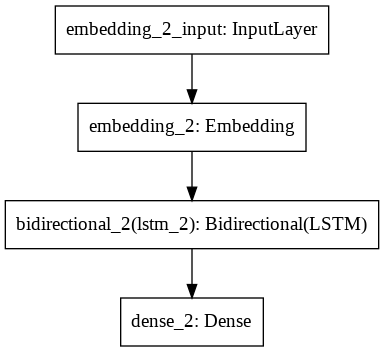

In [127]:
# Initialising the model

vocab_size = len(list(set(Data['Character'].to_list())))+1
output_embedding_dim = 64
input_length = max_len_char_idx
model_bilstm = RNN_architecture(vocab_size, 64, input_length, X_train.shape[1])
plot_model(model_bilstm)

Training the model

In [128]:
def training(features, labels, model):
  history = model.fit(features, labels, batch_size=256, verbose=2, epochs=60, validation_split=0.1)
  return history


# Training the model
results = training(X_train, y_train, model_bilstm)

Epoch 1/60
10/10 - 9s - loss: 0.3423 - accuracy: 0.9646 - recall_2: 0.7613 - precision_2: 0.9829 - val_loss: 0.1038 - val_accuracy: 0.9772 - val_recall_2: 0.9772 - val_precision_2: 0.9772
Epoch 2/60
10/10 - 5s - loss: 0.0829 - accuracy: 0.9802 - recall_2: 0.9802 - precision_2: 0.9802 - val_loss: 0.0838 - val_accuracy: 0.9772 - val_recall_2: 0.9772 - val_precision_2: 0.9772
Epoch 3/60
10/10 - 5s - loss: 0.0741 - accuracy: 0.9802 - recall_2: 0.9802 - precision_2: 0.9802 - val_loss: 0.0807 - val_accuracy: 0.9772 - val_recall_2: 0.9772 - val_precision_2: 0.9772
Epoch 4/60
10/10 - 5s - loss: 0.0723 - accuracy: 0.9802 - recall_2: 0.9802 - precision_2: 0.9802 - val_loss: 0.0779 - val_accuracy: 0.9772 - val_recall_2: 0.9772 - val_precision_2: 0.9772
Epoch 5/60
10/10 - 5s - loss: 0.0700 - accuracy: 0.9802 - recall_2: 0.9802 - precision_2: 0.9802 - val_loss: 0.0753 - val_accuracy: 0.9771 - val_recall_2: 0.9770 - val_precision_2: 0.9773
Epoch 6/60
10/10 - 5s - loss: 0.0684 - accuracy: 0.9802 - re

Train and Test scores

In [129]:
loss, acc, recall, precision = model_bilstm.evaluate(X_train, y_train, verbose=2)
print('\nTrain set metrics:')
print("Loss = {}, Accuracy = {}, Recall = {}, Precision = {}\n".format(loss, acc, recall, precision))

loss, acc, recall, precision = model_bilstm.evaluate(X_test, y_test, verbose=2) 
print('\nTest set metrics:')
print("Loss = {}, Accuracy = {}, Recall = {}, Precision = {}\n".format(loss, acc, recall, precision))

87/87 - 6s - loss: 0.0459 - accuracy: 0.9840 - recall_2: 0.9834 - precision_2: 0.9846

Train set metrics:
Loss = 0.04587560147047043, Accuracy = 0.9839559197425842, Recall = 0.9834139347076416, Precision = 0.9845986366271973

10/10 - 1s - loss: 0.0480 - accuracy: 0.9835 - recall_2: 0.9831 - precision_2: 0.9840

Test set metrics:
Loss = 0.047979552298784256, Accuracy = 0.983522355556488, Recall = 0.9830747246742249, Precision = 0.9839913845062256



Visualising the accuracy and training during training

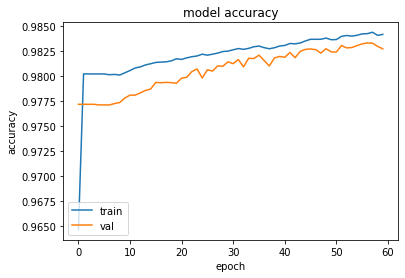

In [130]:
# visualising accuracy during training
import matplotlib.pyplot as plt
%matplotlib inline

plt.plot(results.history['accuracy'])
plt.plot(results.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower left')

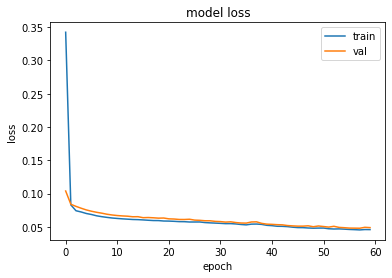

In [131]:
# visualising loss during training
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')


As padding inserts lot of 'O' values to the label matrix, the previous train and test metrics are not true representation of model performance.

#### Measuring model performance by computing the ratio of predicted Named Entities to total ground truth Named Entities


In [158]:
# building the prediction table on X and y dataset

def build_prediction_table(model, X, y, index_to_char, index_to_tag):
  # predictions vector of the model
  resulting_vector = np.argmax(model.predict(X), axis=2)

  ground_truth_vector = np.argmax(y, axis=2)
  
  prediction_char_table = pd.DataFrame({'char_token': pd.Series(X.reshape(-1,).tolist()), 'tag_token': pd.Series(resulting_vector.reshape(-1,).tolist()), 'ground_truth_token': pd.Series(ground_truth_vector.reshape(-1,).tolist())})
  prediction_char_table['chars'] = prediction_char_table['char_token'].map(index_to_char)
  prediction_char_table['tag'] = prediction_char_table['tag_token'].map(index_to_tag)
  prediction_char_table['ground_truth'] = prediction_char_table['ground_truth_token'].map(index_to_tag)

  ground_truth_tags = prediction_char_table['ground_truth'].to_numpy().reshape(ground_truth_vector.shape)
  predicted_tags = prediction_char_table['tag'].to_numpy().reshape(resulting_vector.shape)
  test_words = prediction_char_table['chars'].to_numpy().reshape(X.shape)
  predictions = pd.DataFrame({'words': test_words.tolist(), 'predicted_tags': predicted_tags.tolist(), 'ground_truth_tags': ground_truth_tags.tolist()})
  return predictions

In [159]:
# function to output predicted as well as ground truth Named entities

def output_predicted_named_entities(prediction_table):
  predicted_named_entities = [] # list of predicted Named entities
  ground_truth_named_entities = [] # list of ground truth Named enitities


  for row in range(prediction_table.shape[0]):
    test_sentence = prediction_table.loc[row, 'words']
    test_tag = prediction_table.loc[row, 'predicted_tags']
    ground_truth_tag = prediction_table.loc[row, 'ground_truth_tags']
    test_tag = ''.join(test_tag) # transforming list into sentence
    ground_truth_tag = ''.join(ground_truth_tag)

    # finding character sequences which have tag as BI...IB 
    list_of_matched_indices = [(m.start(0), m.end(0)) for m in re.finditer(r'B[I]+B', test_tag)] 
    match_in_ground_truth_tags = [(m.start(0), m.end(0)) for m in re.finditer(r'B[I]+B', ground_truth_tag)]
    
    # listing the named entities and ground truth named entities
    named_entity = [''.join(test_sentence[x[0]:x[1]]) for x in  list_of_matched_indices]
    ground_truth_named_entity = [''.join(test_sentence[x[0]:x[1]]) for x in match_in_ground_truth_tags]

    if (len(named_entity)>0):
      for ne in named_entity:
        predicted_named_entities.append(ne)
    if (len(ground_truth_named_entity)>0):
      for ne in ground_truth_named_entity:
        ground_truth_named_entities.append(ne)

  
  return predicted_named_entities, ground_truth_named_entities

In [165]:
# Computing Accuracy of the model

# Model accuracy over the train set
train_predictions = build_prediction_table(model_bilstm, X_train, y_train, index_to_char, index_to_tag)
train_predicted_NE, train_ground_truth_NE = output_predicted_named_entities(train_predictions)
print("Train Accuracy: {}%".format(len(train_predicted_NE)*100/len(train_ground_truth_NE)))

# Model accuracy over the test set
test_predictions = build_prediction_table(model_bilstm, X_test, y_test, index_to_char, index_to_tag)
test_predicted_NE, test_ground_truth_NE = output_predicted_named_entities(test_predictions)
print("Test Accuracy: {}%".format(len(test_predicted_NE)*100/len(test_ground_truth_NE)))

Train Accuracy: 11.140080587817017%
Test Accuracy: 11.90965092402464%


* The above performance measure indicates that the model is underfitting.
* This is due to small size of the dataset (only around 3085 unique sentences)

## Treating word as the training instance

Grouping by the words

In this case, the model is trained over words with each character of the word as the input unit. The model predicts tags for each character in the word. Finally the words with the predicted tag as BI...IB are classified as Named Entities. 

In [132]:
Data_group_2 = Data.groupby('Word_index')[['Character', 'Tag', 'Character_index', 'Tag_index']].agg(list)

* The character index sequence will be the training sequence.
* Tag_index will be the label sequence. 
* both of them will be padded so that their final length are the same.
* Tag_index will be in one hot encoded format before training.

In [133]:
# max len for the training sequence
max_len_char_idx = max([len(c) for c in Data_group_2['Character_index'].to_list()])

char_idx_sequences = Data_group_2['Character_index'].to_list()
tag_idx_sequences = Data_group_2['Tag_index'].to_list()
X_2 = pad_sequences(char_idx_sequences, maxlen=max_len_char_idx, padding='post', value=len(char_to_index)) # padding with next number to the last index
y_2 = pad_sequences(tag_idx_sequences, maxlen=max_len_char_idx, padding='post', value=tag_to_index['O']) # padding with outer 'O' values

# one hot encoding the elements of y
y_2 = [to_categorical(i, num_classes=3) for i in y_2] # taking only 3 classes 'B', 'I', 'O'

In [134]:
y_2 = np.array(y_2)

print(X_2.shape)
print(y_2.shape)

(68504, 66)
(68504, 66, 3)


splitting the data set into train and test set

In [135]:
# splitting into train and test set (80% and 20%)

from sklearn.model_selection import train_test_split

X_train_perword, X_test_perword, y_train_perword, y_test_perword = train_test_split(X_2, y_2, test_size=0.20, random_state=42)

In [136]:
y_train_perword = np.array(y_train_perword)
y_test_perword = np.array(y_test_perword)
print(X_train_perword.shape, X_test_perword.shape)
print(y_train_perword.shape, y_test_perword.shape)

(54803, 66) (13701, 66)
(54803, 66, 3) (13701, 66, 3)


Instantiating the Bidirectional LSTM model

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_3 (Embedding)      (None, 66, 64)            6976      
_________________________________________________________________
bidirectional_3 (Bidirection (None, 66, 132)           69168     
_________________________________________________________________
dense_3 (Dense)              (None, 66, 3)             399       
Total params: 76,543
Trainable params: 76,543
Non-trainable params: 0
_________________________________________________________________


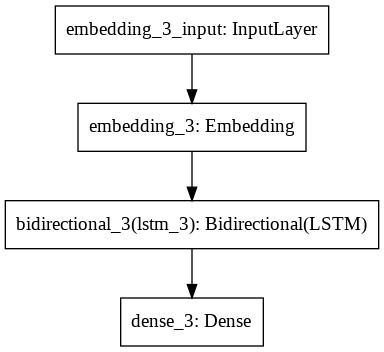

In [137]:
# Instantiating the Bidirectional LSTM model

vocab_size = len(list(set(Data['Character'].to_list())))+1
output_embedding_dim = 64
input_length = max_len_char_idx

# model
model_bilstm_perword = RNN_architecture(vocab_size, 64, input_length, X_train_perword.shape[1])


plot_model(model_bilstm_perword)

In [138]:
# Training the model
results_perword = training(X_train_perword, y_train_perword, model_bilstm_perword)

Epoch 1/60
193/193 - 6s - loss: 0.0793 - accuracy: 0.9875 - recall_3: 0.9515 - precision_3: 0.9926 - val_loss: 0.0265 - val_accuracy: 0.9924 - val_recall_3: 0.9924 - val_precision_3: 0.9924
Epoch 2/60
193/193 - 3s - loss: 0.0240 - accuracy: 0.9926 - recall_3: 0.9923 - precision_3: 0.9930 - val_loss: 0.0233 - val_accuracy: 0.9926 - val_recall_3: 0.9920 - val_precision_3: 0.9934
Epoch 3/60
193/193 - 3s - loss: 0.0217 - accuracy: 0.9930 - recall_3: 0.9924 - precision_3: 0.9936 - val_loss: 0.0210 - val_accuracy: 0.9930 - val_recall_3: 0.9925 - val_precision_3: 0.9934
Epoch 4/60
193/193 - 3s - loss: 0.0200 - accuracy: 0.9932 - recall_3: 0.9928 - precision_3: 0.9936 - val_loss: 0.0193 - val_accuracy: 0.9932 - val_recall_3: 0.9928 - val_precision_3: 0.9935
Epoch 5/60
193/193 - 3s - loss: 0.0185 - accuracy: 0.9935 - recall_3: 0.9932 - precision_3: 0.9938 - val_loss: 0.0176 - val_accuracy: 0.9937 - val_recall_3: 0.9934 - val_precision_3: 0.9940
Epoch 6/60
193/193 - 3s - loss: 0.0173 - accuracy:

Train and Test scores

In [139]:
loss, acc, recall, precision = model_bilstm_perword.evaluate(X_train_perword, y_train_perword, verbose=2)
print('\nTrain set metrics:')
print("Loss = {}, Accuracy = {}, Recall = {}, Precision = {}\n".format(loss, acc, recall, precision))

loss, acc, recall, precision = model_bilstm_perword.evaluate(X_test_perword, y_test_perword, verbose=2)
print('\nTest set metrics:')
print("Loss = {}, Accuracy = {}, Recall = {}, Precision = {}".format(loss, acc, recall, precision))

1713/1713 - 9s - loss: 0.0075 - accuracy: 0.9973 - recall_3: 0.9973 - precision_3: 0.9974

Train set metrics:
Loss = 0.007506593130528927, Accuracy = 0.9973397850990295, Recall = 0.9973149299621582, Precision = 0.9973592758178711

429/429 - 2s - loss: 0.0107 - accuracy: 0.9963 - recall_3: 0.9963 - precision_3: 0.9964

Test set metrics:
Loss = 0.010670101270079613, Accuracy = 0.9963473081588745, Recall = 0.9963240623474121, Precision = 0.9963637590408325


Visualising the model accuracy and loss during training

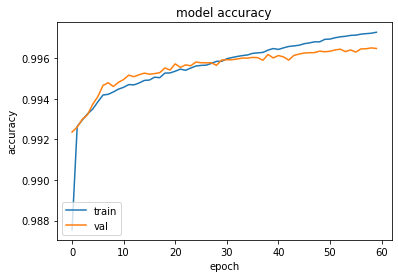

In [140]:
# visualising accuracy
plt.plot(results_perword.history['accuracy'])
plt.plot(results_perword.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='lower left')

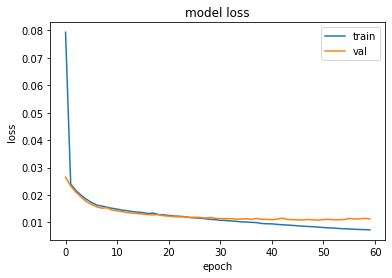

In [141]:
# visualising loss
plt.plot(results_perword.history['loss'])
plt.plot(results_perword.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')

##### Measuring model performance by computing the ratio of predicted Named Entities to total ground truth Named Entities

In [166]:
# Computing Performance of the model

# Accuracy of the model over the train set
train_predictions = build_prediction_table(model_bilstm_perword, X_train_perword, y_train_perword, index_to_char, index_to_tag)
train_predicted_NE, train_ground_truth_NE = output_predicted_named_entities(train_predictions)
print("Train Accuracy: {}%".format(len(train_predicted_NE)*100/len(train_ground_truth_NE)))

# Accuracy of the model over the test set
test_predictions = build_prediction_table(model_bilstm_perword, X_test_perword, y_test_perword, index_to_char, index_to_tag)
test_predicted_NE, test_ground_truth_NE = output_predicted_named_entities(test_predictions)
print("Test Accuracy: {}%".format(len(test_predicted_NE)*100/len(test_ground_truth_NE)))

Train Accuracy: 73.94291754756871%
Test Accuracy: 71.25813449023862%


* The above accuracy shows that performance of this model that is based on the words as instances, performs much better on the given dataset than the sentence based model.